In [1]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyDOE as doe
from scipy.special import legendre
random.seed(106) # fixing the random seed

In [2]:
PCEord = 7
rho0= 1
LogAlpStart = -4
hypPrPar = 1e-05

In [3]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Ndim = np.size(Xobs,1)

In [4]:
CMD = 'gen_mi -p '+str(PCEord)+' -q '+str(Ndim)+' >> out.log'
os.system(CMD)
PCEmi = np.loadtxt('mindex.dat')
Nphi = np.size(PCEmi,0)
print(M,Ndim,PCEord,Nphi)

300 3 7 120


In [5]:
K = 1 # number of kernels
LogAlp0 = LogAlpStart*np.array([1]*Nphi)
rCoeff = hypPrPar*np.ones((1,Nphi)) 
sCoeff = hypPrPar*np.ones((1,Nphi))
muVec  = np.zeros((Nphi,K))
SigMat = np.zeros((Nphi,Nphi,K))
Phi = np.zeros((M,Nphi))
for i in range(0,M):
    for j in range(0,Nphi):
        tmp = 1.0
        for k in range(0,Ndim):
            tmp = tmp*np.polyval(legendre(PCEmi[j,k]),Xobs[i,k])
        Phi[i,j] = tmp
pTpinv = la.inv(Phi.T@Phi)
#print(la.eig(Phi.T@Phi))
mtmp = np.dot(Yobs,(np.eye(M) - Phi@pTpinv@Phi.T)@Yobs)
muVec[:,0] = pTpinv@Phi.T@Yobs
SigMat[:,:,0] = pTpinv/rho0 
#print(np.exp(-0.5*rho0*mtmp),mtmp,np.sqrt(la.det(pTpinv)),aCoeff[0,0])

In [6]:
def NSBL(logalpIN):
    alp = np.exp(logalpIN)
    A = np.diag(alp)
    Ainv = np.diag(1/alp)
    Bmat = np.zeros((Nphi,Nphi,K))
    Pmat = np.zeros((Nphi,Nphi,K))
    mVec = np.zeros((Nphi,K))
    wVec = np.zeros((1,K))
    vVec = np.zeros((Nphi,K))
    vbarVec = np.zeros((Nphi,1))
    jVec = np.zeros((Nphi,1))
    Hmat = np.zeros((Nphi,Nphi))
    for k in range(0,K):
        Bmat[:,:,k] = SigMat[:,:,k] + Ainv
        Pmat[:,:,k] = Ainv - Ainv@la.inv(Bmat[:,:,k])@Ainv
        mVec[:,k]   = Pmat[:,:,k]@la.inv(SigMat[:,:,k])@muVec[:,k]
        wVec[0,k]   = st.multivariate_normal.pdf(muVec[:,k],[0]*Nphi,Bmat[:,:,k])
        for ii in range(0,Nphi):
            vVec[ii,k] = 0.5*(1.0 - alp[ii]*(Pmat[ii,ii,k] + mVec[ii,k]**2))
    evid = np.sum(wVec)
    wVec = wVec/evid
    objFun = np.log(evid) + np.dot(rCoeff[0,:],logalpIN) - np.dot(sCoeff[0,:],alp)
    for ii in range(0,Nphi):
        vbarVec[ii,0] = np.dot(wVec[0,:],vVec[ii,:])
        jVec[ii,0]   = vbarVec[ii,0] + rCoeff[0,ii] - sCoeff[0,ii]*alp[ii]
        for jj in range(0,ii):
            Hmat[ii,jj] = Hmat[jj,ii]
        for jj in range(ii,Nphi):
            tmpij = 1.0 if ii==jj else 0.0
            for k in range(0,K):
                Hmat[ii,jj] = Hmat[ii,jj] + wVec[0,k]*(alp[ii]*alp[jj]*(0.5*Pmat[ii,jj,k]**2 \
                                    + mVec[ii,k]*mVec[jj,k]*Pmat[ii,jj,k]) \
                                    + vVec[jj,k]*(vVec[ii,k] - vbarVec[ii,0]))
            Hmat[ii,jj] = Hmat[ii,jj] + tmpij*(vbarVec[ii,0] - sCoeff[0,ii]*alp[ii] - 0.5)
    return np.log(evid), objFun, jVec[:,0], Hmat

In [7]:
def myFun(xin):
    _, Otmp, Jtmp, _ = NSBL(xin)
    return -Otmp, -Jtmp
def myFunb(xin):
    _, Otmp, _, _ = NSBL(xin)
    return -Otmp
def myFunHess(xin):
    _, _, _, Htmp = NSBL(xin)
    return -Htmp

In [8]:
maxIter = 100
ftol = 1e-10
jtol = 1e-10
#res = sopt.minimize(myFun, LogAlp0, method='Newton-CG',jac=True, hess=myFunHess, \
#                    options={'maxiter':maxIter,'return_all': True,'xtol':ftol})
#res = sopt.minimize(myFun, LogAlp0, method='trust-ncg',jac=True, hess=myFunHess, \
#                    options={'maxiter':maxIter,'return_all': True,'gtol':jtol})
res = sopt.minimize(myFun, LogAlp0, method='trust-exact',jac=True, hess=myFunHess, \
                    options={'maxiter':maxIter,'return_all': True,'gtol':jtol})
#print(res)

In [9]:
LogAlpIter = np.zeros((res.nit,Nphi))
fevalIter = np.zeros((res.nit,2))
for i in range(0,res.nit):
    LogAlpIter[i,:] = res.allvecs[i]
    fevalIter[i,0], fevalIter[i,1], _, _ = NSBL(LogAlpIter[i,:])
for i in range(0,Nphi):
    if np.exp(res.x[i]) < 1.0:
        print(i,np.exp(res.x[i])) 
np.savetxt('SBLnl_feval.dat',fevalIter[:,1])
print(LogAlpIter[0,:],fevalIter[0,0],fevalIter[0,1])
print('log-evid',fevalIter[-1,1])

0 0.08155353946004384
1 0.1251419066923765
7 0.5719119639197111
10 0.08470453602892776
15 0.035414485142503074
30 0.02917756567409833
40 0.024120271878639493
49 0.21359482723163528
77 0.041808343934968434
89 0.7647214210763753
98 0.1571439426996215
[-4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.
 -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.
 -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.
 -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.
 -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.
 -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.
 -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4. -4.] -353.2972093528461 -353.30203133161274
log-evid -58.65814332201879


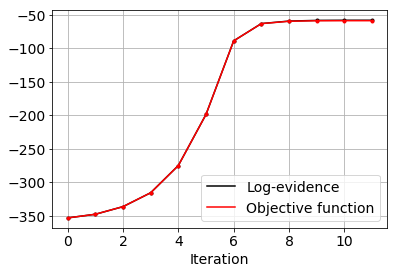

In [10]:
mpl.rcParams.update({'font.size':14})
plt.figure(1)
plt.plot(fevalIter[:,0],'k.')
plt.plot(fevalIter[:,0],'k-',label='Log-evidence')
plt.plot(fevalIter[:,1],'r.')
plt.plot(fevalIter[:,1],'r-',label='Objective function')
#plt.legend(loc='best', numpoints = 1)
plt.legend(loc='lower right', numpoints = 1)
plt.grid(True)
plt.xlabel('Iteration')
plt.savefig('plot_feval.eps',bbox_inches='tight')